In [1]:
import numpy as np
import matplotlib.pyplot as plt
import anaflow 
import scipy.special as sc
import sympy as sp
import mpmath as mp

In [2]:
"""
Построим общее решение уравнения фильтрации с использованием sympy
"""
# определим переменные с которыми будем работать 
t_d = sp.symbols('t_d', real=True, positive=True)
r_d = sp.symbols('r_d', real=True, positive=True)
p_d = sp.symbols('p_d', cls=sp.Function, real=True, positive=True)
Lp_d = sp.symbols(r'\widetilde{p_d}', cls=sp.Function, 
                  real=True, positive=True)
u = sp.symbols('u',real=True, positive=True)
A, B = sp.symbols('A B')
q_d = sp.symbols('q_D', real=True, positive=True)
Lq_d = sp.symbols(r'\widetilde{q_D}', real=True, positive=True)

# определим уравнение фильтрации в пространстве Лапласа
diff_eq = sp.Eq(u * Lp_d(r_d),
                1/r_d * (sp.diff(r_d*sp.diff(Lp_d(r_d), r_d), r_d)))
# отобразим полученное уравнение
display(diff_eq)

Eq(u*\widetilde{p_d}(r_d), (r_d*Derivative(\widetilde{p_d}(r_d), (r_d, 2)) + Derivative(\widetilde{p_d}(r_d), r_d))/r_d)

In [3]:
dq_d = sp.symbols('dq_d', real=True, positive=True)

In [4]:
# граничное условие на скважине
print('граничное условие на скважине')
eq_boundary = sp.Eq(r_d * sp.diff(p_d(r_d,t_d), r_d) , -dq_d * t_d)
display(eq_boundary)

граничное условие на скважине


Eq(r_d*Derivative(p_d(r_d, t_d), r_d), -dq_d*t_d)

In [46]:


"""
применим преобразование Лапласа к обеим частям граничного условия
используя sympy преобразование Лапласа
"""
eq_boundary_Laplace = sp.Eq(
    sp.laplace_transform(eq_boundary.lhs, t_d, u, noconds=True),  
    sp.laplace_transform(eq_boundary.rhs, t_d, u, noconds=True)
                            )
print('граничное условие на скважине в пространстве Лапласа')
display(eq_boundary_Laplace)
"""
зададим в явном виде решение с использованием K_0 и I_0
будем далее работать с этим решением
"""
A, B = sp.symbols('A B')
soln2 = sp.Eq(Lp_d(r_d) , 
              A * sp.besselk(0, r_d * sp.sqrt(u)) + 
              B * sp.besseli(0, r_d * sp.sqrt(u)))
soln2
"""
Общее условие с учетом B=0
"""
soln3 = soln2.subs(B, 0)
soln3
"""
Подставим общее решение в выражение для граничного условия 2
"""
bc2 = sp.Eq(r_d * soln3.rhs.diff(r_d), eq_boundary_Laplace.rhs)
bc2
"""
найдем А решив алгебраическое уравнение
"""
# определим символ для безразмерного радиуса скважины
r_wd = sp.symbols('r_wd', real=True, positive=True)
# решим алгебраическое уравнение
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
# выведем все решения
print('решения для бесконечного пласта')
display(bc2_sol)
"""
подставим полученное решение в уравнение  
получим решение для произвольного радиуса скважины
"""
soln4 = soln3.subs(A, bc2_sol[0])
print('решение в пространстве Лапласа')
soln4

граничное условие на скважине в пространстве Лапласа


Eq(r_d*LaplaceTransform(Derivative(p_d(r_d, t_d), r_d), t_d, u), -dq_d/u**2)

решения для бесконечного пласта


[dq_d/(r_wd*u**(5/2)*besselk(1, r_wd*sqrt(u)))]

решение в пространстве Лапласа


Eq(\widetilde{p_d}(r_d), dq_d*besselk(0, r_d*sqrt(u))/(r_wd*u**(5/2)*besselk(1, r_wd*sqrt(u))))

In [47]:
"""
Найдем предел решения для конечного радиуса скважины при 
стремлении радиуса скважины к нулю
"""
soln6 = sp.Eq(soln4.lhs, sp.limit(soln4.rhs, r_wd, 1))
soln6

Eq(\widetilde{p_d}(r_d), dq_d*besselk(0, r_d*sqrt(u))/(u**(5/2)*besselk(1, sqrt(u))))

In [48]:
pd_linq = sp.lambdify([u, r_d, dq_d], soln6.rhs, modules=["scipy","numpy"]) 

In [49]:
# функция расчета безразмерного давления на основе
# численного обратного преобразования Лапласа
def pd_lineq_inv(td, r_d=1., dq_d=1.):
    """
    расчет решения линейного стока для безразмерного давления
    на основе численного обратного преобразования Лапласа 
    (алгоритм Стефеста)
    t_d - безразмерное давление, число или numpy массив
    r_d - безразмерный радиус, по умолчанию rd=1 - соответствует
         давлению на забое, должно быть числом
    результат массив массивов давления от времени
    """
    td = np.where(td>0, td, 0.001)
    pd_inv = anaflow.get_lap_inv(pd_linq, r_d=r_d, dq_d=dq_d) 
    return pd_inv(td) * np.heaviside(td, 0)

In [50]:
pd_lineq_inv1 = np.vectorize(pd_lineq_inv)

In [51]:

# Решение линейного стока уравнения фильтрации
def pd_lin_ei(td, rd=1, dqd_dtd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, 
    # даже если td массив и нулевой только один элемент
    td = np.array(td, dtype = float)
    pd =  (1 + rd**2/4/td) * (-sc.expi(-rd**2/4/td)) - np.exp(-rd**2/4/td)
    return dqd_dtd * td * pd / 2 * np.heaviside(td, 0)

In [52]:
 pd_lineq_inv(tdd, dq_d=[-1])

array([-2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -2.35416951e-05, -2.35416951e-05,
       -2.35416951e-05, -2.35416951e-05, -7.39264783e-04, -3.75508747e-03,
       -7.95814278e-03, -

In [53]:
pd_lin_ei(tdd, dqd_dtd=[-1])

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.26837410e-16, -3.95331759e-08,
       -4.09434704e-06, -

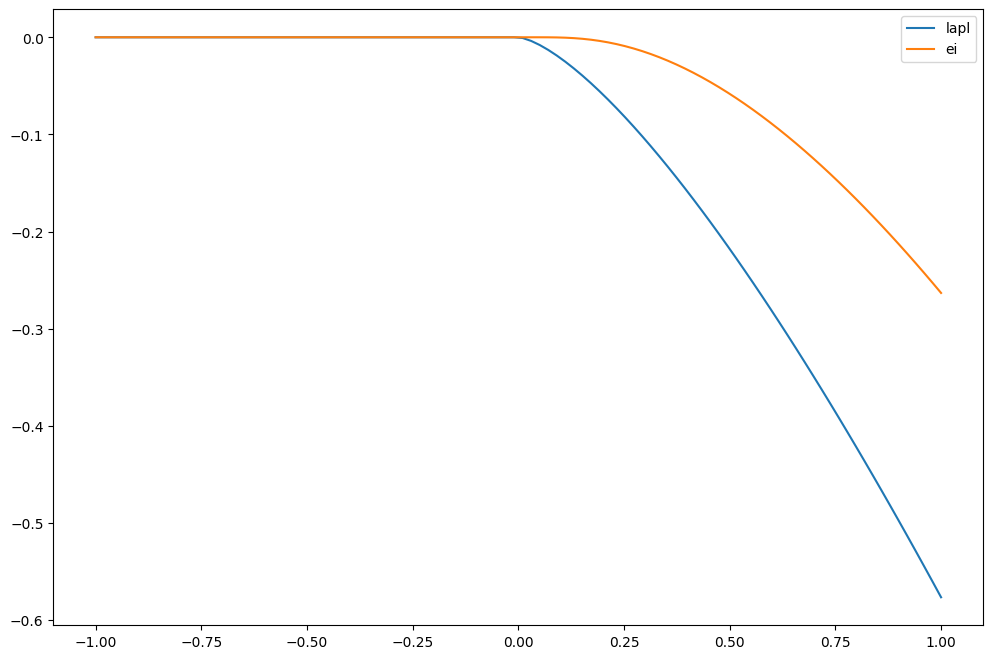

In [54]:
tdd =np.linspace(-1,1,100)
plt.plot(tdd, pd_lineq_inv(tdd, dq_d=-1), label = 'lapl')
plt.plot(tdd, pd_lin_ei(tdd, dqd_dtd=-1), label='ei')
plt.legend()
plt.show()

In [55]:
def pd_superposition_lin(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности 
    безразмерных дебитов
    - td -  время расчета после запуска, безразмерное
    - td_hist - массив времен изменения режимов работы, безразмерное
    - qd_hist - массив дебитов после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, 
    # чтобы учесть запуск скважины
    qdh = np.hstack([qd_hist])
    tdh = np.hstack([td_hist])
    # построим дебиты виртуальных скважин 
    # разности реальных дебитов при переключении
    delta_qd = np.hstack([np.diff(qdh),0])
    delta_td = np.hstack([np.diff(tdh),1])
    
    dq_dt = delta_qd / delta_td
    dq_dt = np.diff(np.hstack([0, delta_qd / delta_td]))
    
    # референсный безразмерный дебит это 1
    
    # векторная магия - время как вектор и переключения дебитов тоже 
    # организуем сумму по временам, внутри сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    
    dpd = np.cumsum(pd_lin_ei((td_v - tdh), 
                              dqd_dtd=dq_dt) * np.heaviside((td_v - tdh), 1),1 )

    return dpd[:,-1]

def pd_superposition_lin1(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности 
    безразмерных дебитов
    - td -  время расчета после запуска, безразмерное
    - td_hist - массив времен изменения режимов работы, безразмерное
    - qd_hist - массив дебитов после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, 
    # чтобы учесть запуск скважины
    qdh = np.hstack([qd_hist])
    tdh = np.hstack([td_hist])
    # построим дебиты виртуальных скважин 
    # разности реальных дебитов при переключении
    delta_qd = np.hstack([np.diff(qdh),0])
    delta_td = np.hstack([np.diff(tdh),1])
    
    dq_dt = delta_qd / delta_td
    dq_dt = np.diff(np.hstack([0, delta_qd / delta_td]))
    
    # референсный безразмерный дебит это 1
    
    # векторная магия - время как вектор и переключения дебитов тоже 
    # организуем сумму по временам, внутри сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    
    dpd = np.cumsum(pd_lineq_inv1((td_v - tdh), 
                              dq_d=dq_dt) * np.heaviside((td_v - tdh), 1),1 )

    return dpd[:,-1]

def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

C:\Users\rnt\AppData\Local\Temp\ipykernel_4580\643557215.py:11: RuntimeWarning: divide by zero encountered in divide
  pd =  (1 + rd**2/4/td) * (-sc.expi(-rd**2/4/td)) - np.exp(-rd**2/4/td)
C:\Users\rnt\AppData\Local\Temp\ipykernel_4580\643557215.py:11: RuntimeWarning: invalid value encountered in multiply
  pd =  (1 + rd**2/4/td) * (-sc.expi(-rd**2/4/td)) - np.exp(-rd**2/4/td)


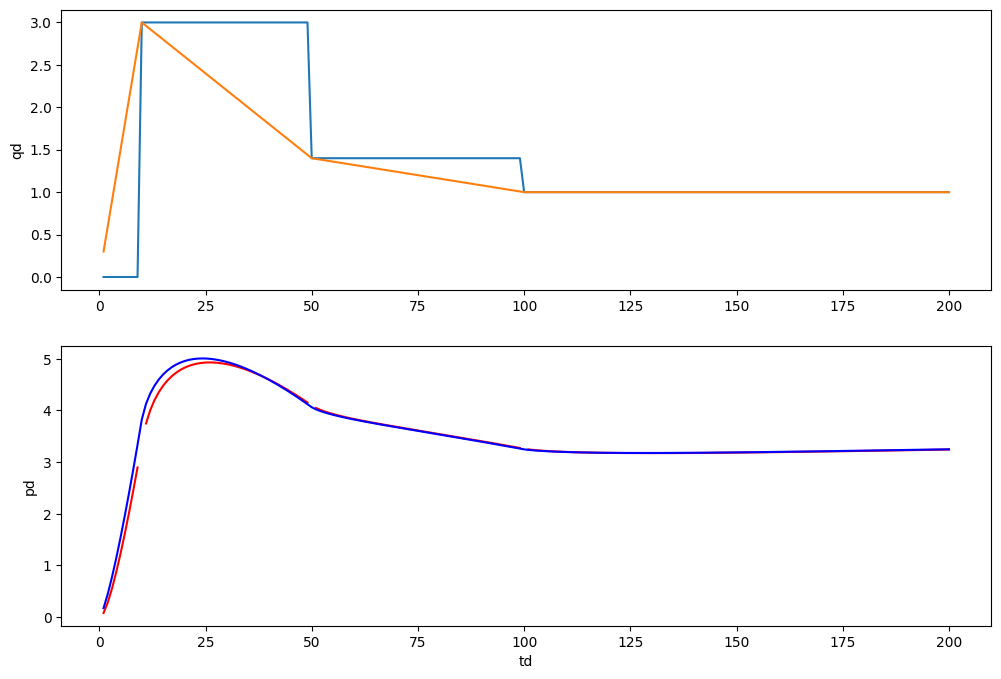

In [56]:
td_arr = np.linspace(1, 200, 200)


td_history = np.array([0., 10, 50, 100 ], dtype=np.float64) 
qd_history = np.array([0., 3, 1.4, 1.0], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,8)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax1.plot(td_arr, np.interp(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, 
         pd_superposition_lin(td_arr, td_history, qd_history), 
         color='red') 
ax2.plot(td_arr, 
         pd_superposition_lin1(td_arr, td_history, qd_history), 
         color='blue') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()